<h1> Modelo de clasificacion </h1>

David Jimenez Cooper

Este proyecto tiene como finalidad crear un clasificador de las consultas publicas de Banco de México con el objetivo de comunicar oportunamente a todos los comités de ABM que tengan algun impacto por la consulta.

# Paso 1. Cargar librerias

In [3]:
# Dataframes y series
import pandas as pd
import numpy as np

# Graficar
import matplotlib.pyplot as plt
import seaborn as sns

# Scikitlearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_curve,
    auc,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    precision_recall_curve
)

# NLP
import re
from collections import Counter

#import gensim  # para cargar modelo w2v

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

import tensorflow
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    LSTM,
    Embedding,
    Dense,
    TimeDistributed,
    Dropout,
    Bidirectional,
    Flatten,
    GlobalAveragePooling1D,
    MaxPool1D,
    GRU,
    Concatenate
    )
from tensorflow.keras.initializers import Constant
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import GlobalMaxPooling1D

# Guardar
import pickle

# Paso 2. Carga de base de datos

In [ ]:
# Definimos la ruta de la base de datos
ruta_datos = 'https://raw.githubusercontent.com/AnIsAsPe/LogisticRegression_SpamOpinion/master/Datos/deceptive-opinion.csv'

In [ ]:
# Importamos los datos a un dataframe
df = pd.read_csv(ruta_datos)

# Paso 3. Exploración de la base de datos

In [ ]:
# Informacion basica del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   deceptive  1600 non-null   object
 1   hotel      1600 non-null   object
 2   polarity   1600 non-null   object
 3   source     1600 non-null   object
 4   text       1600 non-null   object
dtypes: object(5)
memory usage: 62.6+ KB


In [ ]:
# Visualizar los primeros registros
df.head()

,deceptive,hotel,polarity,source,text
0,truthful,conrad,positive,TripAdvisor,We stayed for a one night getaway with family ...
1,truthful,hyatt,positive,TripAdvisor,Triple A rate with upgrade to view room was le...
2,truthful,hyatt,positive,TripAdvisor,This comes a little late as I'm finally catchi...
3,truthful,omni,positive,TripAdvisor,The Omni Chicago really delivers on all fronts...
4,truthful,hyatt,positive,TripAdvisor,I asked for a high floor away from the elevato...


In [ ]:
# Visualizar los ultimos registros
df.tail()

,deceptive,hotel,polarity,source,text
1595,deceptive,intercontinental,negative,MTurk,Problems started when I booked the InterContin...
1596,deceptive,amalfi,negative,MTurk,The Amalfi Hotel has a beautiful website and i...
1597,deceptive,intercontinental,negative,MTurk,The Intercontinental Chicago Magnificent Mile ...
1598,deceptive,palmer,negative,MTurk,"The Palmer House Hilton, while it looks good i..."
1599,deceptive,amalfi,negative,MTurk,"As a former Chicagoan, I'm appalled at the Ama..."


In [ ]:
# Obtenemos cuantas reseñas son positivas y cuantas negativas de acuerdo con la variable polarity
df['polarity'].value_counts()

,count
polarity,
positive,800
negative,800


In [ ]:
# Obtenemos cuantas reseñas son positivas y cuantas negativas de acuerdo con la variable polarity
df['deceptive'].value_counts()

,count
deceptive,
truthful,800
deceptive,800


In [ ]:
df.loc[df['deceptive']=='truthful','polarity'].value_counts()

,count
polarity,
positive,400
negative,400


In [ ]:
# Promedio de longitud de cada texto
df['length'] = df['text'].str.len()
print(f"Promedio de longitud de las reseñas: {df['length'].mean()}")
df.head()

Promedio de longitud de las reseñas: 806.39125


,deceptive,hotel,polarity,source,text,length
0,truthful,conrad,positive,TripAdvisor,We stayed for a one night getaway with family ...,572
1,truthful,hyatt,positive,TripAdvisor,Triple A rate with upgrade to view room was le...,286
2,truthful,hyatt,positive,TripAdvisor,This comes a little late as I'm finally catchi...,1104
3,truthful,omni,positive,TripAdvisor,The Omni Chicago really delivers on all fronts...,707
4,truthful,hyatt,positive,TripAdvisor,I asked for a high floor away from the elevato...,384


In [ ]:
# Funcion para graficar la densidad de un conjunto de columnas espcificadas diferenciando por otra variable categorica
def plot_kde_columns(data, columns, hue=None, nrows=2, ncols=3):
    fig, axes = plt.subplots(nrows, ncols, figsize=(18, 12))
    axes = axes.flatten()

    for i, col in enumerate(columns):
        ax = axes[i]

        # Si hue es None, graficar solo la densidad de los datos, sin diferenciación por hue
        if hue:
            sns.kdeplot(data=data, x=col, hue=hue, fill=True, ax=axes[i])
            axes[i].set_title(f'Distribución de {col} por {hue}')
        else:
            sns.kdeplot(data=data, x=col, fill=True, ax=axes[i])
            axes[i].set_title(f'Distribución de {col}')

        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Densidad')

    # Eliminar los ejes sobrantes en caso de que haya menos columnas que subplots
    for j in range(len(columns), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

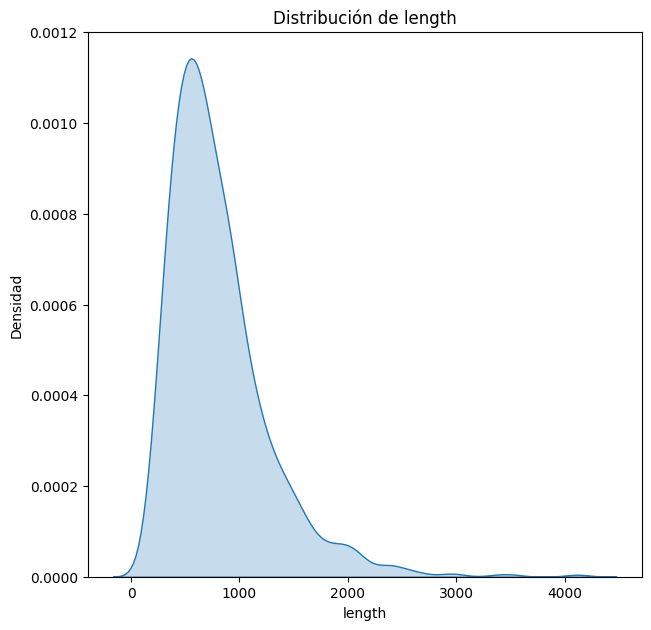

In [ ]:
# Graficamos un histograma con las longitudes de cada texto para ver la densidad
plot_kde_columns(df, ['length'])

In [ ]:
# Obtenemos ciertos cuantiles de acuerdo con el histograma anterior
df['length'].quantile([0.5, 0.75, 0.95, 0.99, 0.995, 0.9975,1])

,length
0.5000,700.000
0.7500,987.500
0.9500,1688.500
0.9900,2424.160
0.9950,2735.940
0.9975,3360.255
1.0000,4159.000


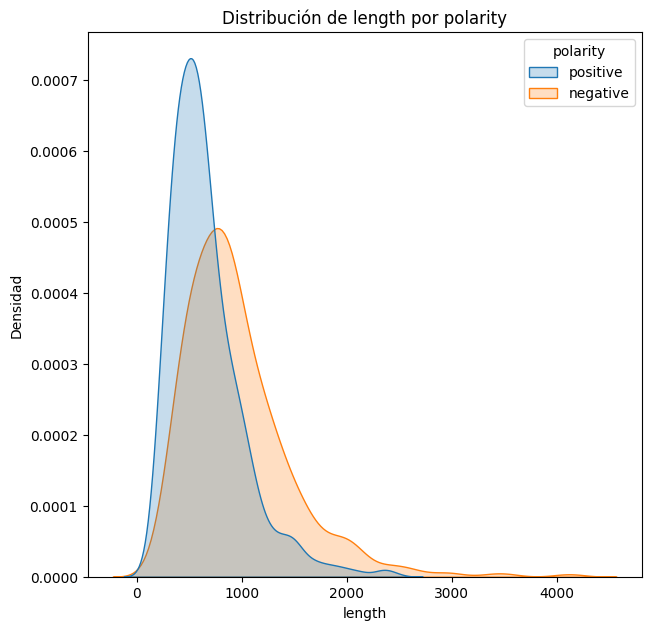

In [ ]:
# Observamos si existe alguna diferencia respecto a la categoria de la reseña
plot_kde_columns(df, ['length'], hue='polarity')

In [ ]:
# Obtenemos ciertos cuantiles de las reseñas negatgivas que tienden a ser mas largas
df.loc[df['polarity']=='negative', 'length'].quantile([0.5, 0.75, 0.95, 0.99, 0.995, 0.9975,1])

,length
0.5000,854.5000
0.7500,1168.2500
0.9500,1949.5500
0.9900,2736.8800
0.9950,3360.5100
0.9975,3539.3425
1.0000,4159.0000


## Hallazgos

Tenemos una base de datos de 1600 reseñas, de las cuales 800 son positivas y 800 son negativas. Puede ser un poco obvio, pero a la vez interesante ver que aquellas negativas tienden a ser mas largas, por lo cual creo necesario tomar una longitud larga para evitar crear un sesgo

# Paso 4. Procesamiento

## 4.1 Obtenemos el vocabulario de los textos

In [ ]:
# Funcion para obtener todo el vocabulario de las reseñas
def get_vocabulario(pandas_series):
    """
    Procesa una serie de pandas con cadenas de texto y devuelve una lista con todas las palabras y signos de puntuación
    que contiene, ordenadas de mayor a menor frecuencia.

    Args:
        pandas_series (pandas.Series): Serie de pandas que contiene frases o cadenas de texto.

    Returns:
        list: Lista de palabras y signos de puntuación ordenadas por frecuencia, desde la más común hasta la menos común.
    """
    # Unir todas las frases de la serie en una sola cadena de texto
    texto = " ".join(sec for sec in pandas_series)

    # Usar expresiones regulares para separar palabras y puntuaciones
    lista_palabras = re.findall(r'\w+|[^\w\s]', texto)

    # Contar la frecuencia de cada palabra o signo usando Counter
    x = Counter(lista_palabras)

    # Devolver solo las palabras, ordenadas por frecuencia de mayor a menor
    return [i for i, _ in x.most_common()]


In [ ]:
def get_dict_map(token_or_tag,pandas_series):
    """
    Crea dos diccionarios de mapeo: uno que convierte tokens o etiquetas a índices y otro que convierte índices a tokens o etiquetas.

    Dependiendo de si `token_or_tag` es 'token' o 'tag', la función crea los diccionarios para tokens (palabras) o etiquetas
    (tags de clasificación, como etiquetas de secuencias en tareas de NLP).

    Args:
        token_or_tag (str): Si es 'token', se genera un diccionario para los tokens de las oraciones;
                            si es 'tag', se genera un diccionario para las etiquetas.

    Returns:
        tuple: Una tupla con dos diccionarios:
            - tok2idx (dict): Diccionario que mapea cada token o etiqueta a un índice.
            - idx2tok (dict): Diccionario que mapea cada índice a su token o etiqueta correspondiente.
    """
    if token_or_tag == 'token':
        # Si se están procesando los tokens, añadimos 'PAD_token' al vocabulario.
        # 'PAD_token' es un token especial que se usará para hacer padding de las oraciones, asegurando que todas
        # tengan la misma longitud.
        vocab = ['PAD_token'] + get_vocabulario(pandas_series)  # 'vocabulario' genera una lista de palabras a partir de las oraciones.

    elif token_or_tag == 'tag':
        # Si se están procesando las etiquetas (tags), se genera el vocabulario a partir de las etiquetas de las oraciones.
        vocab = get_vocabulario(pandas_series)

    # Crear un diccionario que mapea índices a tokens/etiquetas
    idx2tok = {idx: tok for idx, tok in enumerate(vocab)}

    # Crear un diccionario que mapea tokens/etiquetas a índices
    tok2idx = {tok: idx for idx, tok in enumerate(vocab)}

    # Retornar ambos diccionarios: de token/etiqueta a índice y de índice a token/etiqueta
    return tok2idx, idx2tok


In [ ]:
# Crear los diccionarios para los tokens y las etiquetas
token2idx, idx2token = get_dict_map('token',df['text'])  # Diccionarios para los tokens

## 4.2 Preparamos las secuencias para introducirlas al modelo

In [ ]:
# Definimos la longitud de la reseñas a ingresar al modelo. Tomamos el cuantil 90%
max_len = int(df.loc[df['polarity']=='negative', 'length'].quantile(0.90))+1
max_len

1581

In [ ]:
# Creamos las secuencias de los textos y la variable objetivo
df['text_idx'] = df['text'].apply(lambda x: list(map(token2idx.get, re.findall(r'\w+|[^\w\s]', x))))
df['polarity_val'] = np.where(df['polarity'] == 'positive', 1, 0).astype(int)
df

,deceptive,hotel,polarity,source,text,length,text_idx,polarity_val
0,truthful,conrad,positive,TripAdvisor,We stayed for a one night getaway with family ...,572,"[36, 59, 13, 7, 54, 62, 735, 23, 254, 28, 7, 4...",1
1,truthful,hyatt,positive,TripAdvisor,Triple A rate with upgrade to view room was le...,286,"[3672, 294, 296, 23, 663, 5, 130, 15, 8, 432, ...",1
2,truthful,hyatt,positive,TripAdvisor,This comes a little late as I'm finally catchi...,1104,"[88, 1198, 7, 230, 410, 42, 6, 10, 262, 283, 4...",1
3,truthful,omni,positive,TripAdvisor,The Omni Chicago really delivers on all fronts...,707,"[12, 335, 29, 114, 3675, 28, 45, 4475, 3, 43, ...",1
4,truthful,hyatt,positive,TripAdvisor,I asked for a high floor away from the elevato...,384,"[6, 171, 13, 7, 239, 136, 182, 43, 2, 477, 4, ...",1
...,...,...,...,...,...,...,...,...
1595,deceptive,intercontinental,negative,MTurk,Problems started when I booked the InterContin...,746,"[3526, 739, 61, 6, 169, 2, 636, 29, 583, 16, 2...",0
1596,deceptive,amalfi,negative,MTurk,The Amalfi Hotel has a beautiful website and i...,671,"[12, 405, 64, 125, 7, 184, 326, 4, 2184, 2883,...",0
1597,deceptive,intercontinental,negative,MTurk,The Intercontinental Chicago Magnificent Mile ...,771,"[12, 1008, 29, 594, 438, 12, 429, 11, 2, 14, 3...",0
1598,deceptive,palmer,negative,MTurk,"The Palmer House Hilton, while it looks good i...",449,"[12, 524, 466, 196, 3, 170, 17, 729, 93, 9, 83...",0


In [ ]:
# Ajustamos las secuencias de las reseñas para fijar el largo
pad_tokens = pad_sequences(df['text_idx'], maxlen=max_len,
                           dtype='int32', padding='post',
                           value = token2idx['PAD_token'])

df['polarity_val'] = df['polarity_val'].astype(int)
tags = df['polarity_val']


## 4.3 Obtenemos la matriz de encajes para el vocabulario

<h2> Modelo Preentrenado Word2Vec<h3>

Utilizaremos los vectores word2vec preentrenados con el corpus GoogleNews.
Cuenta con 3 millones vectores de 300 dimensiones correspondientes a 3 millones de palabras y frases en inglés.
Está disponible en este [enlace](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?resourcekey=0-wjGZdNAUop6WykTtMip30g)

In [ ]:
# Conexion con drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Obtenemos el modelo preentrenado de word2vec
# %%time

# file_w2vec =  '/content/drive/MyDrive/ML_&_AI_for_the_Working_Analyst/Examen_modulo_3_RNN/GoogleNews-vectors-negative300.bin.gz'
# w2v = gensim.models.KeyedVectors.load_word2vec_format(file_w2vec,  binary=True)

In [ ]:
# Creamos un diccionario de nuestro vocabulario y su correspondiente representacion de vectores
# dic_tokens_word2vec  = {}
# palabras_sin_embedding =[]
# for token in token2idx.keys():
#   try:
#     dic_tokens_word2vec[token] = w2v[token]
#   except:
#     palabras_sin_embedding.append(token)

In [ ]:
# Guardamos el diccionario acotado para uso posterior
dic_tokens_word2vec_path = '/content/drive/MyDrive/ML_&_AI_for_the_Working_Analyst/Examen_modulo_3_RNN'
# pickle.dump(dic_tokens_word2vec, open (dic_tokens_word2vec_path + "dic_tokens_ner_w2v.pkl", 'wb'))

In [ ]:
# Importamos el diccionario de vectores para su uso
dic_tokens_word2vec = pickle.load(open(dic_tokens_word2vec_path + "dic_tokens_ner_w2v.pkl", 'rb'))
palabras_sin_embedding = [tok for tok in token2idx.keys() if tok not in dic_tokens_word2vec.keys()]

In [ ]:
# Vemos cuantas palabras no tienen un vector asociado
print(f'Palabras sin embedding: {len(palabras_sin_embedding)}')

Palabras sin embedding: 712


In [ ]:
# Observamos cuales son para ver si es necesario hacer algun ajuste
palabras_sin_embedding[:100]

['PAD_token',
 '.',
 ',',
 'and',
 'to',
 'a',
 "'",
 'of',
 '-',
 '!',
 ')',
 '(',
 '/',
 ':',
 '?',
 ';',
 '10',
 '30',
 '20',
 '15',
 '00',
 '24',
 '50',
 '100',
 '40',
 '200',
 '45',
 'didnt',
 '11',
 '25',
 '14',
 '12',
 '13',
 '300',
 '99',
 '400',
 '10th',
 '42',
 '2010',
 'travelling',
 '17',
 '2007',
 '75',
 '16',
 '80',
 '30pm',
 '48',
 '29th',
 '35',
 '2009',
 '30am',
 '70',
 '250',
 'theatre',
 '65',
 'centre',
 '95',
 '22nd',
 'wasnt',
 '18',
 '55',
 '49',
 'travelzoo',
 '2008',
 '11th',
 'cancelled',
 '60',
 '500',
 '676',
 '21st',
 '14th',
 'travelled',
 '20th',
 '22',
 'fairmont',
 'Couldn',
 '15th',
 '42nd',
 '[',
 ']',
 'theatres',
 '27',
 '312',
 '90',
 '32',
 'isnt',
 '25th',
 '000',
 '69',
 '23rd',
 '89',
 'consierge',
 '350',
 '30th',
 'Kimptons',
 '53',
 '37',
 'talbott',
 '54',
 'bookit']

Observamos que la mayoria corresponden a numeros, puntuacion o palabras mal escritas, por lo cual no deberiamos tener mayor problema.

In [ ]:
# Creamos la matriz de embeddings para inicializar el modelo
num_tokens = len(token2idx.keys())
n_tags = df['polarity_val'].nunique()
embedding_dim = 300
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for token, i in token2idx.items():
  if token in dic_tokens_word2vec.keys():
    embedding_matrix[i] = dic_tokens_word2vec[token]

In [ ]:
pd.DataFrame(embedding_matrix)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.080078,0.104980,0.049805,0.053467,-0.067383,-0.120605,0.035156,-0.118652,0.043945,0.030151,...,-0.071289,-0.030151,-0.013000,0.016357,-0.018311,0.014832,0.005005,0.003662,0.047607,-0.068848
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11193,-0.036865,0.205078,0.086914,-0.051758,0.067871,0.092285,-0.027466,0.390625,0.474609,0.259766,...,0.054932,0.023071,0.182617,0.154297,-0.263672,0.285156,-0.228516,0.061523,-0.026978,0.204102
11194,0.001266,0.014221,-0.071777,-0.248047,-0.314453,0.054932,0.189453,-0.139648,0.417969,0.259766,...,0.193359,0.168945,-0.024536,-0.034180,-0.090820,-0.361328,0.335938,-0.019287,0.123535,0.005188
11195,0.265625,0.231445,0.166016,0.277344,-0.042236,0.494141,-0.291016,0.287109,0.062988,-0.414062,...,0.039551,-0.322266,-0.146484,-0.337891,0.144531,0.148438,0.071777,-0.159180,0.412109,-0.106445
11196,-0.449219,0.185547,-0.013367,0.115723,-0.056396,-0.143555,-0.369141,0.083984,0.074707,-0.324219,...,0.076172,0.016724,0.158203,-0.086426,-0.361328,0.124512,-0.163086,0.177734,-0.060059,0.333984


# Paso 5. Construccion del modelo

Para obtener mismos resultados cada vez que se entrene el modelo, fijaremos semillas.

En la capa de salida se usará una función de activacion sigmoide para poder interpretar la salida como la probabilidad de ser positiva o negativa y hacer la clasifiacion.

In [ ]:
# Fijamos las semillas
from numpy.random import seed
seed(25102024)
tensorflow.random.set_seed(25102024)

In [ ]:
# Dividimos los datos en train y test
train_tokens, test_tokens, train_tags, test_tags = train_test_split(
pad_tokens, tags, test_size=0.1, train_size=0.9, random_state=2020)

print(
f'''train_tokens: {len(train_tokens)}
train_tags: {len(train_tags)}

test_tokens: {len(test_tokens)}
test_tags: {len(test_tags)}'''
)

train_tokens: 1440
train_tags: 1440

test_tokens: 160
test_tags: 160


In [ ]:
# Arquitectura del modelo

input = Input(shape = (max_len,))

# Capa de Embedding
embedding = Embedding(input_dim = num_tokens,
                      output_dim = 300,
                      embeddings_initializer = Constant(embedding_matrix),
                      trainable = False)(input)
# Capa 1 LSTM Bidireccional
LSTM_Bi = Bidirectional(LSTM(units = 200,
                             return_sequences = False, # Solo se quiere el último estado oculto
                             recurrent_dropout = 0.2, dropout = 0.2  # Para evitar sobreajuste
                             ))(embedding)

# Capa de Salida con funcion de activacion sigmoide para poder interpretar como la probabilidad y hacer la clasifiacion binaria
output = Dense(1, activation="sigmoid")(LSTM_Bi)

Classification_model = Model(input, output)  # unión del modelo
Classification_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1581)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 1581, 300)           │       3,359,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 400)                 │         801,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             401 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,161,401 (15.87 MB)

 Trainable params: 802,001 (3.06 MB)

 Non-trainable params: 3,359,400 (12.82 MB)

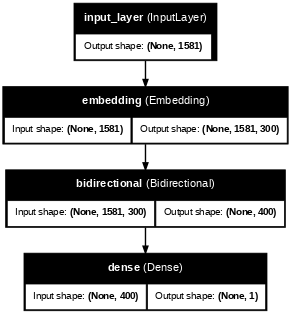

In [ ]:
# Grafica de la arquitectura del modelo
plot_model(
    Classification_model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=50,
)

# Paso 6. Entrenamiento del modelo

In [ ]:
# Compile model
# Classification_model.compile(optimizer='adam',         # el optimizador sirve para encontrar los pesos que minimizan la función de pérdida
#                                             # adam: stochastic gradient descent adaptativo
#                                             # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
#                   loss="binary_crossentropy", # función que evalua que tan bien el algoritmo modela el conjunto de datos
#                                                    # https://www.tensorflow.org/api_docs/python/tf/keras/losses
#                   metrics=['accuracy'])

Se utiliza un callback que ayuda para detener el entrenamiento en caso de que no este mejorando considerablemente. La documebacion se puede revisar en este [enlace](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)

In [ ]:
# # Crear un callback de parada temprana para evitar el sobreajuste
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# # Entrenamiento del modelo
# history = Classification_model.fit(train_tokens, train_tags,
#                         validation_split=0.2,
#                         batch_size=200,
#                         epochs=5,   # número de iteraciones sobre los datos
#                         callbacks=[early_stopping],
#                         verbose=1)



In [ ]:
# Guardar todo el modelo  https://www.tensorflow.org/tutorials/keras/save_and_load
model_path = '/content/drive/MyDrive/ML_&_AI_for_the_Working_Analyst/Examen_modulo_3_RNN/Weights_Clasification.weights.h5'
# Classification_model.save_weights(model_path)

# Leer el modelo guardado
Classification_model.load_weights(model_path)

# Paso 7. Predicción y evaluación

In [ ]:
def evaluate_rnn_classification_model(model, X_test, y_test, predict_threshold):
    """
    Evalúa un modelo de red neuronal recurrente de clasificación binaria en el conjunto de prueba.

    Parámetros:
    modelo: el modelo entrenado de Keras.
    X_test: datos de prueba.
    y_test: etiquetas verdaderas de prueba.

    Retorna:
    Un diccionario con varias métricas de evaluación.
    """
    # Predecir en el conjunto de prueba (esto devuelve probabilidades)
    y_pred_prob = model.predict(X_test)

    # Convertir probabilidades en 0 o 1
    y_pred = (y_pred_prob > predict_threshold).astype(int)

    # Matriz de confusión
    print("Matriz de confusión:")
    confusion = confusion_matrix(y_test, y_pred)
    confusion_percent = confusion / confusion.sum(axis=1, keepdims=True) * 100
    plt.figure(figsize=(6, 6))
    sns.heatmap(confusion_percent, annot=True, fmt=".2f", cmap="Blues", annot_kws={"size": 16})
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix (%)')
    plt.show()
    print("\n")
    print("\n")

    # Curva Precision-Recall
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    pr_auc = auc(recall, precision)
    f1 = f1_score(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.show()
    print("\n")
    print("\n")

    # Curva ROC y AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob.flatten())
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    print("\n")
    print("\n")

    # Reporte de clasificación (Precisión, Recall, F1-score, etc.)
    print("\nReporte de clasificación:")
    print(classification_report(y_test, y_pred))

    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_prob)

    # Diccionario con métricas
    metrics = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "roc_auc": roc_auc
    }

    return metrics


45/45 ━━━━━━━━━━━━━━━━━━━━ 150s 3s/step
Matriz de confusión:


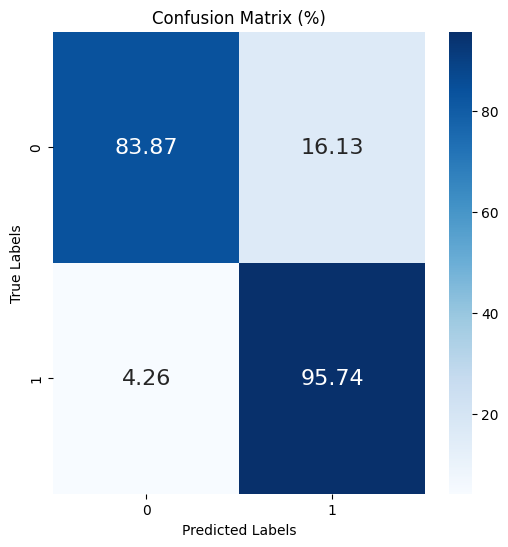

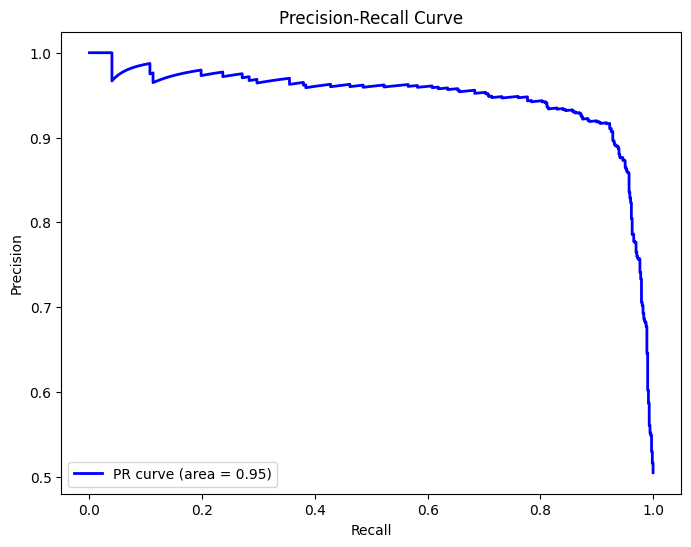

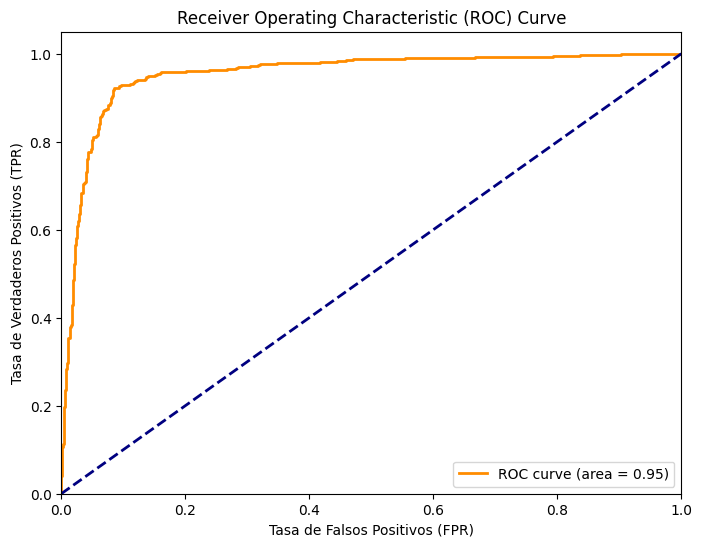






Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.95      0.84      0.89       713
           1       0.86      0.96      0.91       727

    accuracy                           0.90      1440
   macro avg       0.90      0.90      0.90      1440
weighted avg       0.90      0.90      0.90      1440



{'accuracy': 0.8986111111111111,
 'precision': 0.8581997533908755,
 'recall': 0.9573590096286108,
 'f1_score': 0.9050715214564369,
 'roc_auc': 0.9540658742820984}

In [ ]:
# Evaluamos el modelo de clasificacion en el conjunto de entrenamiento
evaluate_rnn_classification_model(Classification_model, train_tokens, train_tags, 0.5)

5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step
Matriz de confusión:


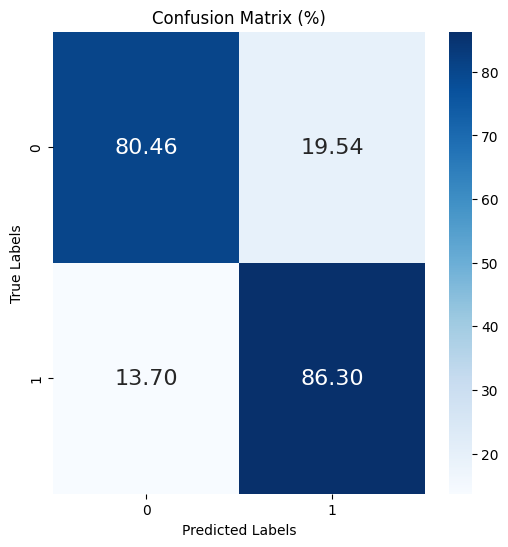

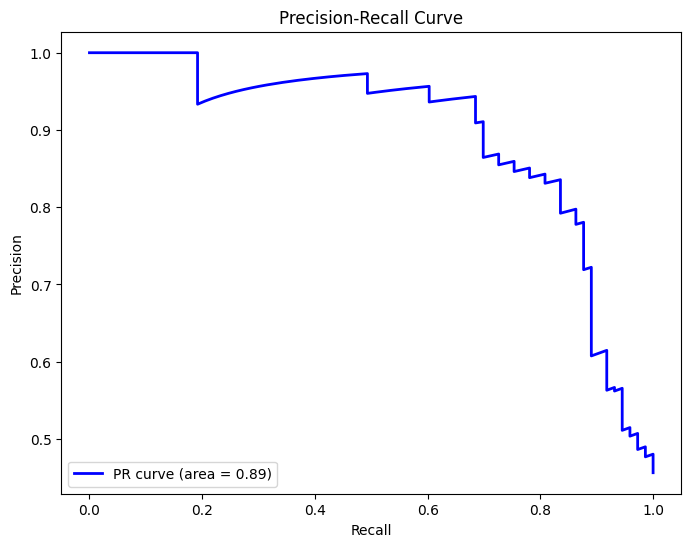

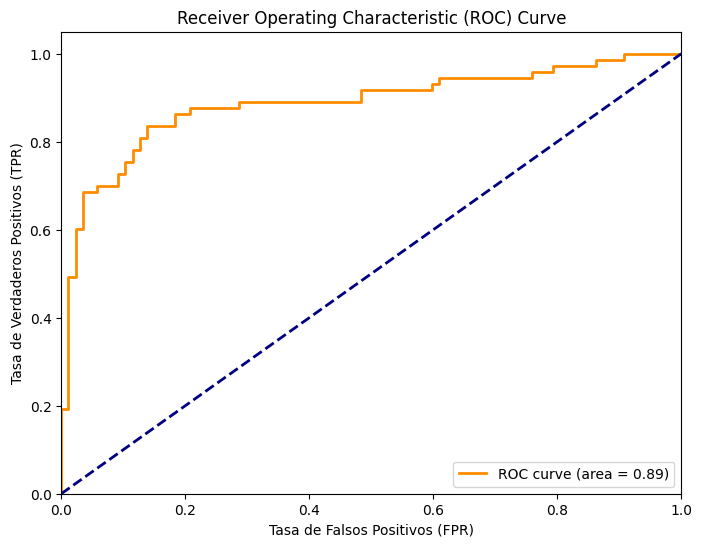






Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.88      0.80      0.84        87
           1       0.79      0.86      0.82        73

    accuracy                           0.83       160
   macro avg       0.83      0.83      0.83       160
weighted avg       0.84      0.83      0.83       160



{'accuracy': 0.83125,
 'precision': 0.7875,
 'recall': 0.863013698630137,
 'f1_score': 0.8235294117647058,
 'roc_auc': 0.8875767595654228}

In [ ]:
# Evaluamos el modelo de clasificacion en el conjunto de validación
evaluate_rnn_classification_model(Classification_model, test_tokens, test_tags, 0.5)

# Propuesta alternativa 2

Se propone crear una capa densa intermedia entre la lstm y la de salida.

En realidad no tengo una razon logica para introducirla, es simplemente para experimentar un poco con la estructura y ver como añadir mas capas

In [ ]:
input = Input(shape = (max_len,))

# Capa de Embedding
embedding = Embedding(input_dim = num_tokens,
                      output_dim = 300,
                      embeddings_initializer = Constant(embedding_matrix),
                      trainable = False)(input)
# Capa 1 LSTM Bidireccional
LSTM_Bi = Bidirectional(LSTM(units = 200,
                             return_sequences = False, # Solo el último estado
                             recurrent_dropout = 0.2, dropout = 0.2  # Para evitar sobreajuste
                             ))(embedding)
# Capa adicional
dense_layer = Dense(50,activation="relu")(LSTM_Bi)

# Capa de Salida
output = Dense(1, activation="sigmoid")(dense_layer)

Classification_model_2 = Model(inputs=input, outputs=output)  # unión del modelo
Classification_model_2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 1581)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 1581, 300)           │       3,359,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 400)                 │         801,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 50)                  │          20,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,181,101 (15.95 MB)

 Trainable params: 821,701 (3.13 MB)

 Non-trainable params: 3,359,400 (12.82 MB)

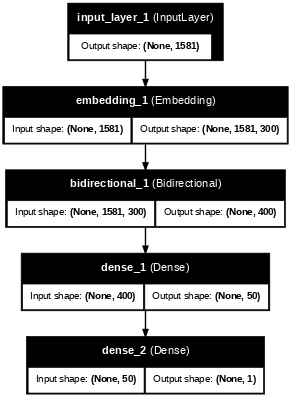

In [ ]:
# Grafica de la arquitectura del modelo
plot_model(
    Classification_model_2,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=50,
)

In [ ]:
# # Compile model
# Classification_model_2.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy'])

# # Crear un callback de parada temprana para evitar el sobreajuste
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# # Entrenamiento del modelo
# history = Classification_model_2.fit(train_tokens, train_tags,
#                         validation_split=0.2,
#                         batch_size=200,
#                         epochs=5,   # número de iteraciones sobre los datos
#                         callbacks=[early_stopping],
#                         verbose=1)


In [ ]:
# Guardar todo el modelo  https://www.tensorflow.org/tutorials/keras/save_and_load
model_path_2 = '/content/drive/MyDrive/ML_&_AI_for_the_Working_Analyst/Examen_modulo_3_RNN/Weights_Clasification_2.weights.h5'
# Classification_model_2.save_weights(model_path_2)

# Leer el modelo
Classification_model_2.load_weights(model_path_2)

45/45 ━━━━━━━━━━━━━━━━━━━━ 126s 3s/step
Matriz de confusión:


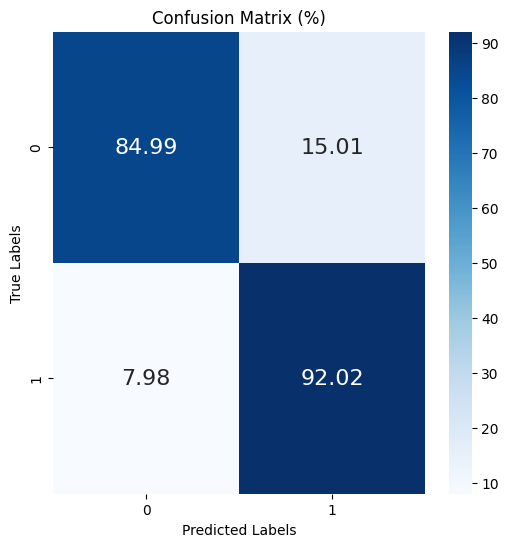

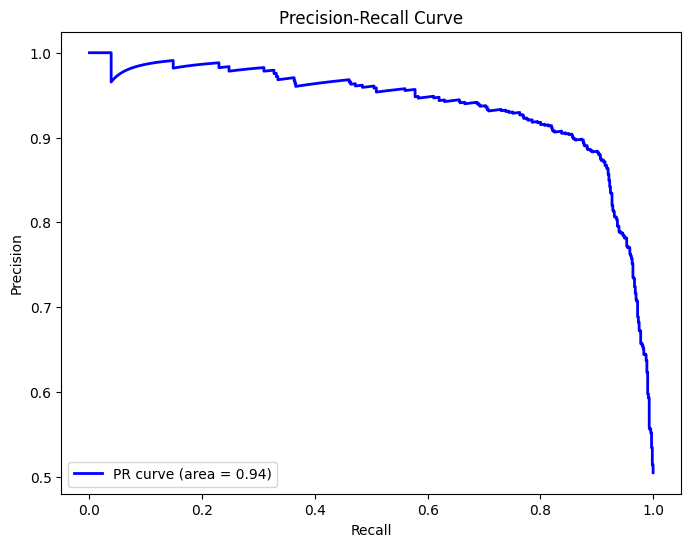

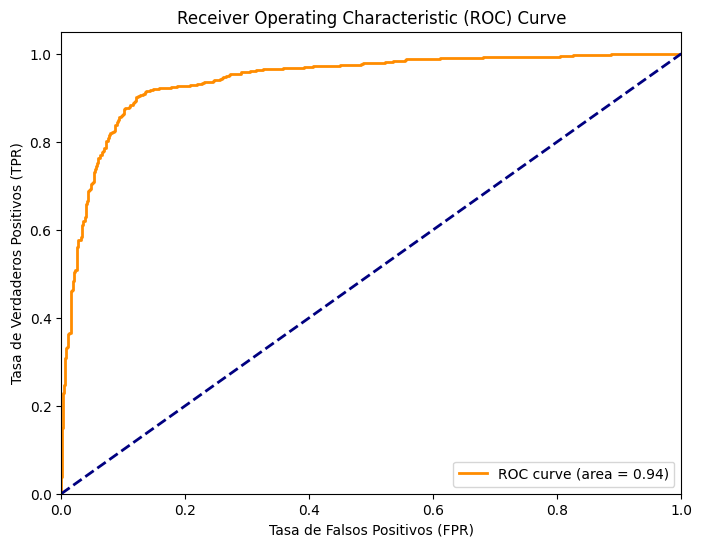






Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.91      0.85      0.88       713
           1       0.86      0.92      0.89       727

    accuracy                           0.89      1440
   macro avg       0.89      0.89      0.89      1440
weighted avg       0.89      0.89      0.89      1440



{'accuracy': 0.8854166666666666,
 'precision': 0.8621134020618557,
 'recall': 0.9202200825309491,
 'f1_score': 0.8902195608782435,
 'roc_auc': 0.9401563805220785}

In [ ]:
# Evaluamos el modelo de clasificacion en el conjunto de entrenamiento
evaluate_rnn_classification_model(Classification_model_2, train_tokens, train_tags, 0.5)

5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step
Matriz de confusión:


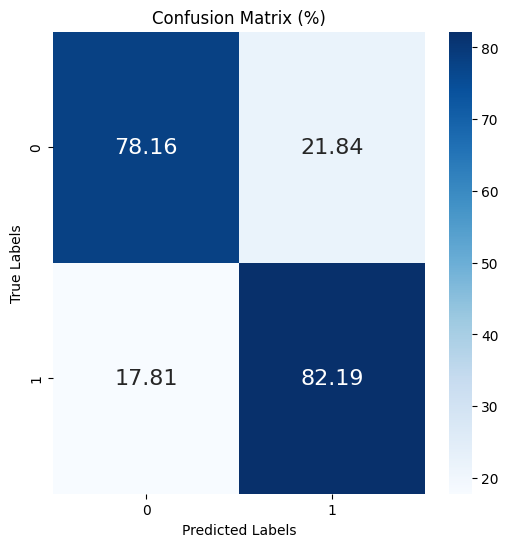

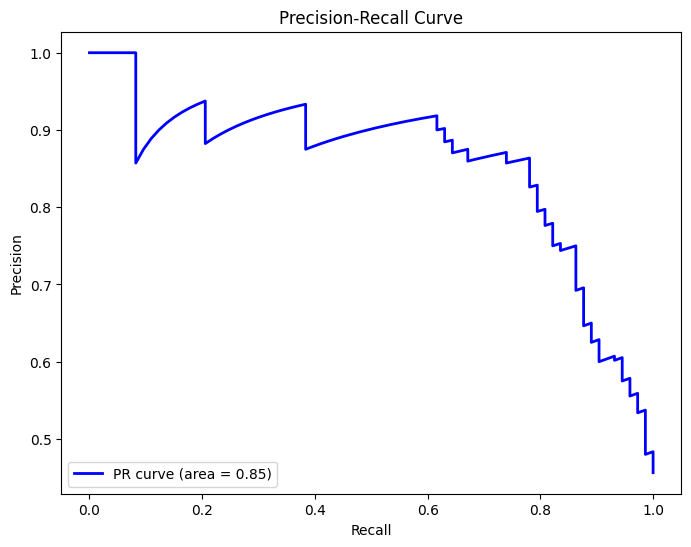

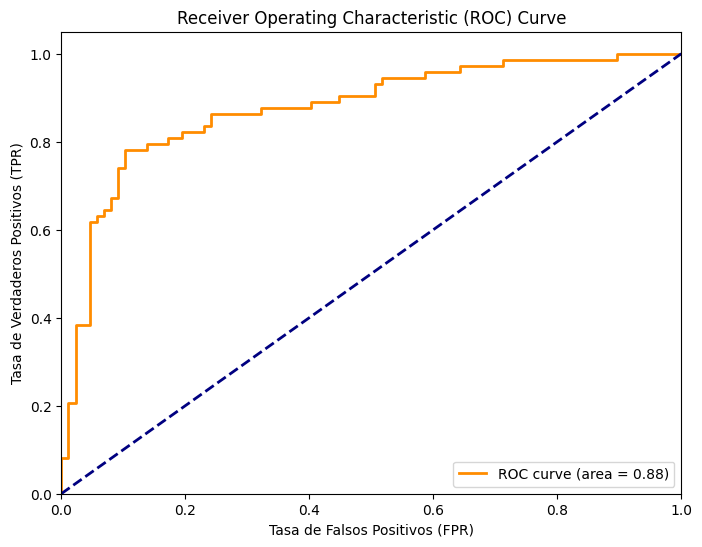






Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.84      0.78      0.81        87
           1       0.76      0.82      0.79        73

    accuracy                           0.80       160
   macro avg       0.80      0.80      0.80       160
weighted avg       0.80      0.80      0.80       160



{'accuracy': 0.8,
 'precision': 0.759493670886076,
 'recall': 0.821917808219178,
 'f1_score': 0.7894736842105263,
 'roc_auc': 0.8767123287671232}

In [ ]:
# Evaluamos el modelo de clasificacion en el conjunto de validación
evaluate_rnn_classification_model(Classification_model_2, test_tokens, test_tags, 0.5)

# Propuesta alternativa 3

Se propone que una capa intermedia que utilice la salida secuencial de lstm antes de la capa de salida, esto podria ayudar a contextualizar en mayor medida a todo el texto.

Para ello se usa Global Max Pooling que tambien ayuda a tomar los valores maximos de cada dimension de entre los vectores representativos de las palabras, lo cual podria ayudar a separar el siginificado negativo del positivo de manera mas general en todo el texto.

In [ ]:
input = Input(shape = (max_len,))

# Capa de Embedding
embedding = Embedding(input_dim = num_tokens,
                      output_dim = 300,
                      embeddings_initializer = Constant(embedding_matrix),
                      trainable = False)(input)
# Capa 1 LSTM Bidireccional
LSTM_Bi = Bidirectional(LSTM(units = 200,
                             return_sequences = True, # Tomamos todos los estados
                             recurrent_dropout = 0.2, dropout = 0.2  # Para evitar sobreajuste
                             ))(embedding)

# Utilizamos Global Max Pooling para poder pasar la informacion secuencial a una capa densa
global_max_pooling = GlobalMaxPooling1D()(LSTM_Bi)

# Capa densa
dense_intermediate = Dense(100, activation='relu')(global_max_pooling)

# Capa de Salida
output = Dense(1, activation="sigmoid")(dense_intermediate)

Classification_model_3 = Model(inputs=input, outputs=output)  # unión del modelo
Classification_model_3.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1581)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 1581, 300)           │       3,359,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 1581, 400)           │         801,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 400)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │          40,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,201,201 (16.03 MB)

 Trainable params: 841,801 (3.21 MB)

 Non-trainable params: 3,359,400 (12.82 MB)

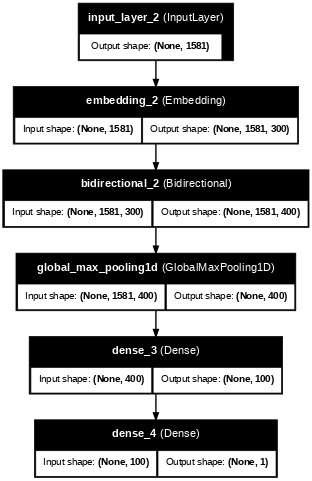

In [ ]:
# Grafica de la arquitectura del modelo
plot_model(
    Classification_model_3,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=50,
)

In [ ]:
# # Compile model
# Classification_model_3.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy'])

# # Crear un callback de parada temprana para evitar el sobreajuste
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# # Entrenamiento del modelo
# history = Classification_model_3.fit(train_tokens, train_tags,
#                         validation_split=0.2,
#                         batch_size=200,
#                         epochs=5,   # número de iteraciones sobre los datos
#                         callbacks=[early_stopping],
#                         verbose=1)


In [ ]:
# Guardar todo el modelo  https://www.tensorflow.org/tutorials/keras/save_and_load
model_path_3 = '/content/drive/MyDrive/ML_&_AI_for_the_Working_Analyst/Examen_modulo_3_RNN/Weights_Clasification_3.weights.h5'
# Classification_model_3.save_weights(model_path_3)

# Leer el modelo guardado
Classification_model_3.load_weights(model_path_3)

45/45 ━━━━━━━━━━━━━━━━━━━━ 149s 3s/step
Matriz de confusión:


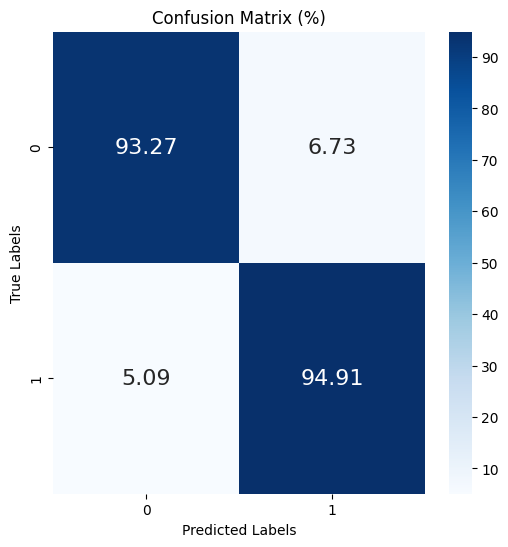

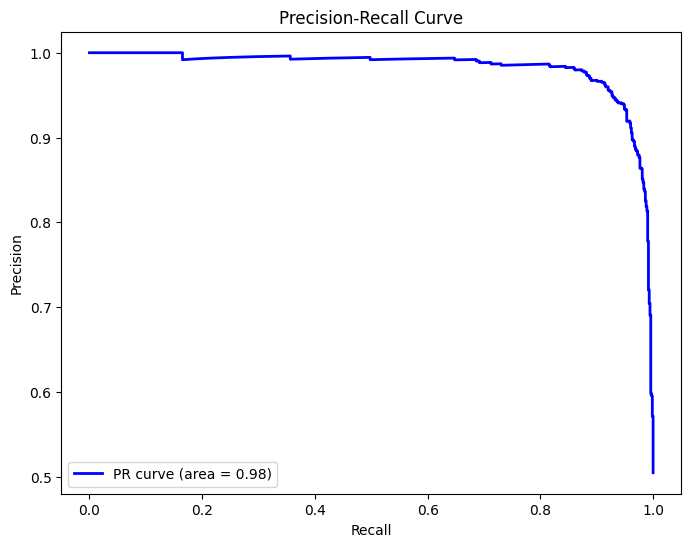

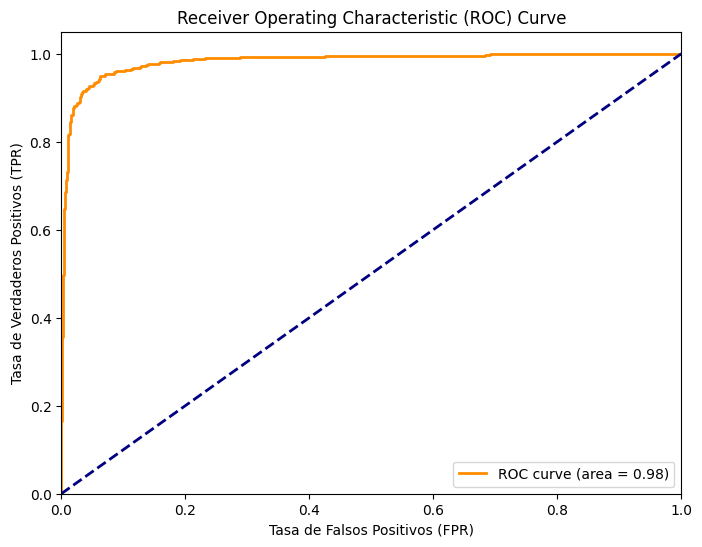






Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       713
           1       0.93      0.95      0.94       727

    accuracy                           0.94      1440
   macro avg       0.94      0.94      0.94      1440
weighted avg       0.94      0.94      0.94      1440



{'accuracy': 0.9409722222222222,
 'precision': 0.9349593495934959,
 'recall': 0.9491059147180193,
 'f1_score': 0.9419795221843004,
 'roc_auc': 0.9827182739109214}

In [ ]:
# Evaluamos el modelo de clasificacion en el conjunto de entrenamiento
evaluate_rnn_classification_model(Classification_model_3, train_tokens, train_tags, 0.5)

5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step
Matriz de confusión:


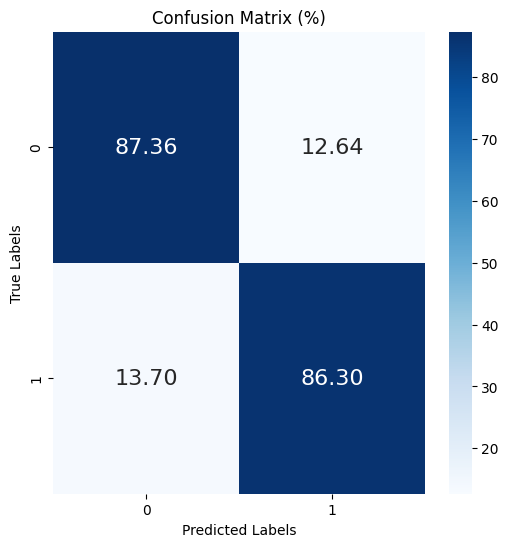

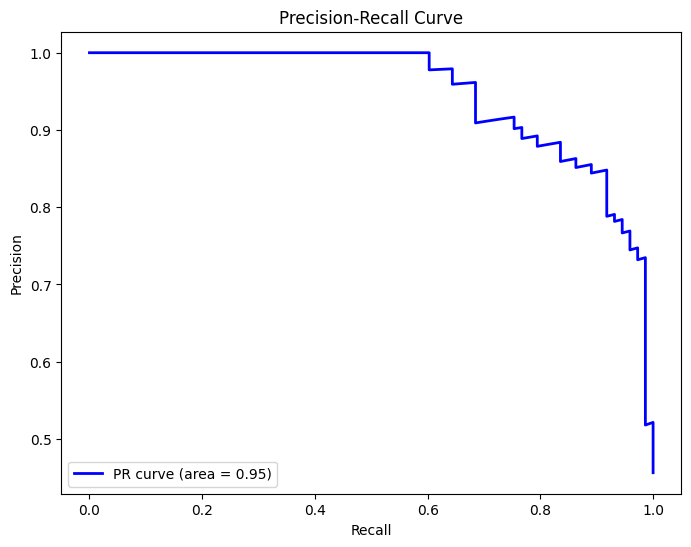

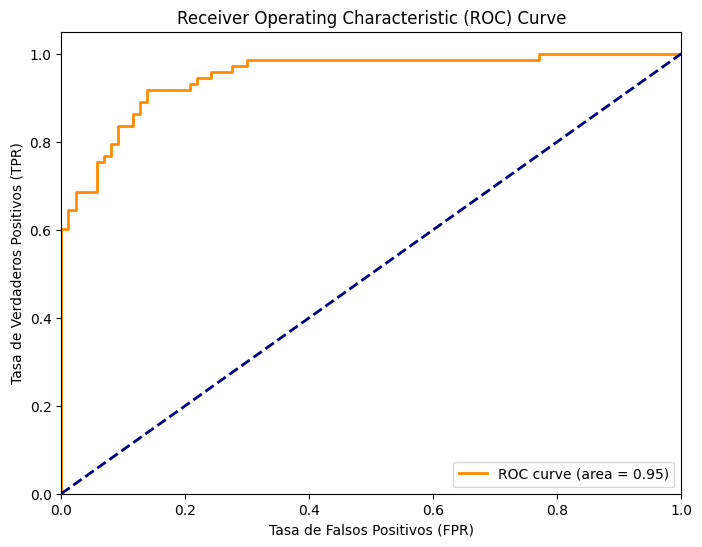






Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.88      0.87      0.88        87
           1       0.85      0.86      0.86        73

    accuracy                           0.87       160
   macro avg       0.87      0.87      0.87       160
weighted avg       0.87      0.87      0.87       160



{'accuracy': 0.86875,
 'precision': 0.8513513513513513,
 'recall': 0.863013698630137,
 'f1_score': 0.8571428571428571,
 'roc_auc': 0.9497716894977168}

In [ ]:
# Evaluamos el modelo de clasificacion en el conjunto de validación
evaluate_rnn_classification_model(Classification_model_3, test_tokens, test_tags, 0.55)

# Conclusiones

La última propuesta en donde se toma los estados ocultos secuenciales de la LSTM para intoducirlos a una capa Global_max y despues a una capa densa antes de la capa de salida mejoró el desempeño del modelo, parece ser que esta si pudo separar con mayor precision las conotaciones negativas o positivas de cada reseña

In [ ]:
# Evaluamos el modelo de clasificacion en el conjunto de validación
evaluate_rnn_classification_model(Classification_model_3, test_tokens, test_tags, 0.55)